In [1]:
# MODIFY! 
model_name = 'ElaNetReg'

# Import Libraries & Data 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('./data/dl-pfe-ns.csv')
X = df.drop('throughput',axis=1)
y = df['throughput']

---

# Scale Data

In [4]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [5]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Determine Hyperparameters

In [6]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Instantiate model (with cross-validation)
from sklearn.linear_model import ElasticNetCV
model = ElasticNetCV(l1_ratio=[.1, .5, .7,.8,.9, .95, .99, 1],max_iter=1000000,cv=10)

In [7]:
model.fit(X_train, y_train)

ElasticNetCV(cv=10, l1_ratio=[0.1, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 1],
             max_iter=1000000)

In [8]:
model.l1_ratio_

0.8

In [9]:
model.alpha_

0.06882738262802143

In [10]:
hp = pd.Series(name=f'{model_name} HP', data=[model.l1_ratio_, model.alpha_],index=['l1_ratio','alpha'])

In [11]:
hp

l1_ratio    0.800000
alpha       0.068827
Name: ElaNetReg HP, dtype: float64

In [12]:
hp.to_csv(f'./hyperparameters/{model_name}-hp.csv')

# Score Model

In [13]:
from sklearn.linear_model import ElasticNet

score_model = ElasticNet(
    alpha = model.alpha_,
    l1_ratio = model.l1_ratio_
)

score_model

ElasticNet(alpha=0.06882738262802143, l1_ratio=0.8)

In [14]:
from sklearn.model_selection import cross_validate

scores = cross_validate(
    score_model, 
    X_train, 
    y_train,
    scoring=[
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_root_mean_squared_error'
    ],
    cv=10
)

In [15]:
scores = pd.DataFrame(scores)

In [16]:
scores

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.008994,0.003162,-3.130511,-16.435944,-4.054127
1,0.011716,0.001665,-3.428564,-19.825176,-4.452547
2,0.008612,0.014279,-2.982968,-16.009678,-4.001210
3,0.013275,0.001839,-3.368803,-18.959225,-4.354219
4,0.006042,0.002593,-3.186693,-17.191308,-4.146240
5,0.008112,0.001649,-3.656134,-23.581192,-4.856047
6,0.036013,0.003139,-3.142689,-16.812133,-4.100260
7,0.018385,0.002703,-3.005153,-14.895729,-3.859499
8,0.030331,0.033402,-2.742093,-12.303085,-3.507575
9,0.008600,0.001762,-2.915067,-16.338455,-4.042085


In [17]:
mean_scores = scores.mean()

In [18]:
mean_scores

fit_time                             0.015008
score_time                           0.006619
test_neg_mean_absolute_error        -3.155868
test_neg_mean_squared_error        -17.235192
test_neg_root_mean_squared_error    -4.137381
dtype: float64

# Export Scores

In [19]:
mean_scores = mean_scores.rename(f'{model_name}')

In [20]:
mean_scores[[2,3,4]] = mean_scores[[2,3,4]].apply(abs)

In [21]:
# mean_scores

In [22]:
mean_scores = mean_scores.rename({
    'fit_time':'Fit Time',
    'score_time':'Score Time',
    'test_neg_mean_absolute_error':'MAE',
    'test_neg_mean_squared_error':'MSE',
    'test_neg_root_mean_squared_error':'RMSE'
})

In [23]:
mean_scores

Fit Time       0.015008
Score Time     0.006619
MAE            3.155868
MSE           17.235192
RMSE           4.137381
Name: ElaNetReg, dtype: float64

In [24]:
mean_scores['STD FT'] = scores.fit_time.std()
mean_scores['STD ST'] = scores.score_time.std()
mean_scores['STD MAE'] = scores.test_neg_mean_absolute_error.std()
mean_scores['STD MSE'] = scores.test_neg_mean_squared_error.std()
mean_scores['STD RMSE'] = scores.test_neg_root_mean_squared_error.std()

In [25]:
mean_scores

Fit Time       0.015008
Score Time     0.006619
MAE            3.155868
MSE           17.235192
RMSE           4.137381
STD FT         0.010260
STD ST         0.010150
STD MAE        0.269473
STD MSE        3.034551
STD RMSE       0.360973
Name: ElaNetReg, dtype: float64

In [26]:
mean_scores.to_csv(f'./scores/{model_name}-score.csv')

# Export Optimized Model

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)

StandardScaler()

In [28]:
# MODIFY! 
X_ela = scaler.transform(X)

ela_model = ElasticNet(
    alpha = model.alpha_,
    l1_ratio = model.l1_ratio_
)

ela_model.fit(X,y)

ElasticNet(alpha=0.06882738262802143, l1_ratio=0.8)

In [29]:
y_pred_ela = model.predict(X_ela)

<AxesSubplot:ylabel='Count'>

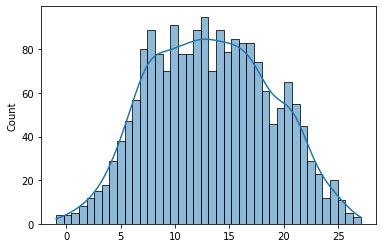

In [30]:
sns.histplot(y_pred_ela,bins=40,kde=True)

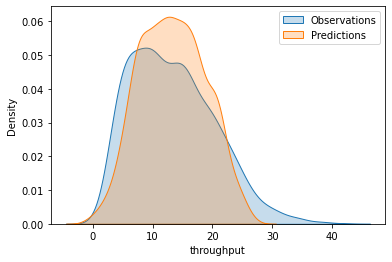

In [31]:
fig,ax = plt.subplots()

sns.kdeplot(y, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_pred_ela, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

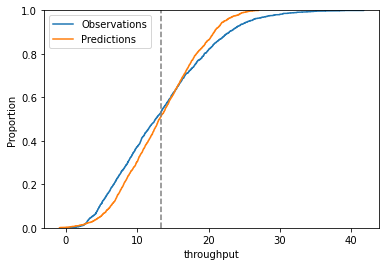

In [32]:
fig,ax = plt.subplots()

sns.ecdfplot(y, ax=ax, label='Observations')
sns.ecdfplot(y_pred_ela, ax=ax,label='Predictions')
plt.axvline(x=y.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y,y_pred_ela)
mse = mean_squared_error(y,y_pred_ela)
rmse = np.sqrt(mse)

In [34]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,ElaNetReg
MAE,3.044861
MSE,16.079293
RMSE,4.009899


In [35]:
err_df.to_csv(f'./model-err/{model_name}-err.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [36]:
from joblib import dump, load
dump(ela_model, f'./opt-models/{model_name}-model.joblib')

['./opt-models/ElaNetReg-model.joblib']

DONE!